





# Phase 1: my own work

In this notebook I will show:
- FBPass for a simple network: one convolutional layer, a max-pooling layer and a dense layer on top - with activation functions for the first and last layer.
- The Network will be used in an example, to classify a very simple pattern. 
    - This is achieved by adding a loss functions - allowing training on a small dataset.
- Lastly: the notebook will look into batching of the training data. Will it change the performance? Train faster? 

In [39]:

import numpy as np
import matplotlib.pyplot as plt
import math


In [40]:
def visualize_image(X, label):
    # Plot "pixels" with numerical value and color map
    fig = plt.figure(figsize=(3, 3))
    ax = fig.add_subplot(1,1,1)
    ax.axis('off')
    ax.imshow(X, cmap="coolwarm")
    ax.title.set_text(label)
    for i in range(X.shape[0]):
        for j in range(X.shape[1]):
            ax.text(j, i, f"{X[i,j]:.2f}", color="black", fontsize="small", ha="center", va="center")

edge1 = np.array([[0,0,0,0,0, 0], [0,1,1,0,0,0], [0,1,0,0,0,0], [0,0,0,0,0,0], [0,0,0,0,0,0], [0,0,0,0,0,0]])
edge2 = np.array([[0,0,0,0,0, 0], [0,0,1,1,0,0], [0,0,1,0,0,0], [0,0,0,0,0,0], [0,0,0,0,0,0], [0,0,0,0,0,0]])
edge3 = np.array([[0,0,0,0,0, 0], [0,0,0,0,0,0], [0,0,0,1,1,0], [0,0,0,1,0,0], [0,0,0,0,0,0], [0,0,0,0,0,0]])

singles1 = np.array([[0,0,0,0,0,0], [0,0,0,0,0,0], [0,0,0,0,1,0], [0,0,0,0,0,0], [0,0,0,0,0,0], [0,0,0,0,0,0]])
singles2 = np.array([[0,0,0,0,0,0], [0,0,1,0,0,0], [0,0,0,0,0,0], [0,0,0,0,0,0], [0,0,0,0,0,0], [0,0,0,0,0,0]])
singles3 = np.array([[0,0,0,0,0,0], [0,0,0,0,0,0], [0,0,0,0,0,0], [0,0,0,0,1,0], [0,0,0,0,0,0], [0,0,0,0,0,0]])


y_train = np.array([1, 1, 1, 0, 0, 0]) # 1 is edge, 0 is no edge
#X_train = np.asarray([edge1, edge2, edge3, no_edge1, no_edge2, no_edge3])
X_train = np.asarray([edge1, edge2, edge3, singles1, singles2, singles3])

X_train.shape

(6, 6, 6)

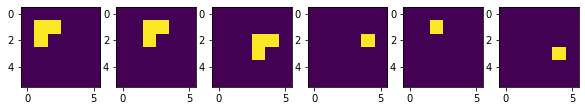

In [41]:
fig, axs = plt.subplots(nrows=1, ncols=6, figsize=(10, 15))
# plotting the loss
axs[0].imshow(X_train[0])
axs[1].imshow(X_train[1])
axs[2].imshow(X_train[2])
axs[3].imshow(X_train[3])
axs[4].imshow(X_train[4])
axs[5].imshow(X_train[5]);

### Simplest case - binary classification
A single convolutional layer, then a a dense layer.

In [42]:
def convolution(X, F, b=0, s=1):
    # Convolutional layer
    # note: no padding and depth=1 just to make calculations a bit simpler
    # Output feature size
    w_out = (X.shape[0] - F.shape[0])//s + 1
    h_out = (X.shape[1] - F.shape[1])//s + 1
    z = np.zeros((h_out, w_out))
    for j in range(0, w_out, s):
        for i in range(0, h_out, s):
            z[i,j] = X[i:i+F.shape[1], j:j+F.shape[0]].flatten().dot(F.flatten()) + b
    return z

def max_pool(X, k, s):
    h_out = (X.shape[0] - k)//s + 1
    w_out = (X.shape[1] - k)//s + 1
    z = np.zeros((h_out, w_out))
    idx = []
    for j in range(0, h_out):
        for i in range(0, w_out):
            block = X[j*k:j*k+k, i*k:i*k+k]
            z[j,i] = np.max(block)
            index = np.add(np.unravel_index(block.argmax(), block.shape), (j*k, i*k))
            idx.append(index) # Save indices of max values for backward pass!
    return z, idx
    
def ReLU(x):
    return abs(x) * (x > 0) # abs just makes -0.0 into 0.0 for easier reading
def d_ReLU(x): # differentiated!
    return 1 * (x > 0)
def sigmoid(x):
    y = np.exp(x)
    return y / (1 + y)
def d_sigmoid(x): # differentiated!
    y = sigmoid(x)
    return y * (1.0 - y)
def bce_loss(y, p):
    # Binary cross-entropy loss function
    return -(y * np.log10(p) + (1-y) * np.log10(1-p))
def d_bce_loss(y,p): # differentiated!
    # Derivative wrt. p
    return (1 - y) / (1 - p) - (y / p)

In [43]:
def simple_fit(X_train, y_train, lr=0.1, epochs=10, verbose=False, scale=255):
    # Initialize randomly
    b1 = 1.0 # conv Bias
    F = np.array([[-0.5,0.5, -0.5],[-0.5,0.5, -0.5], [-0.5,0.5, -0.5]]) # Kernel
    #F = np.array([[0.1,-0.1],[-0.1,0.1]]) # Kernel
    w4 = None 
    b4 = 0 # neuron Bias
    lr = lr # Learning rate
    losses = []

    for e in range(epochs):
        for i, X in enumerate(X_train):        
            X = X/scale # normalize
            ####################
            ### Forward pass ###
            ####################
            # Convolution
            z1 = convolution(X, F, b1, s=1) # Perform convolution
            a1 = ReLU(z1) # Apply AF
            # Maxpool and flatten
            a2, max_idx = max_pool(a1, k=2, s=2)
            a3 = a2.flatten()
            # Initialize to correct size
            if e==0 and i==0:
                w4 = np.random.randn(len(a3))
            # Fully-connected layer
            z4 = w4.dot(a3) + b4
            a4 = sigmoid(z4)
            # Loss
            loss = bce_loss(y_train[i], a4)
            losses.append(loss)

            if math.isnan(losses[-1]):
                # Could not find solution, restarting
                return simple_fit(X_train, y_train, lr=lr, epochs=epochs, verbose=verbose, scale=scale)

            ####################
            ### Backward pass ##
            ####################
            # Fully connected layer:
            delta = d_bce_loss(y_train[i], a4) * d_sigmoid(z4)
            b4 = b4 - lr * delta # Update bias
            delta = delta * a3 # Gradient wrt. w4
            w4 = w4 - lr * delta # Update weights

            # NEXT, we unflatten the backpropagated derivative:
            delta = delta.reshape(a2.shape)
            # maxpooling layer
            d = np.zeros(a1.shape)
            for idx, grad in zip(max_idx, delta.flatten()):
                i, j = idx[0], idx[1]
                d[i,j] = grad
            delta = d
            # Backprop through delta
            delta = d_ReLU(z1) * delta
            # The conv bias
            grad_b1 = delta.sum() # dL/d(b1)
            b1 = b1 - lr * grad_b1 # Update bias
            # The conv kernel
            grad_F = convolution(X, delta)
            F = F - lr * grad_F # Update weights

        if verbose:
            print("Epoch:", e)
            print("loss:", losses[-1])


    model = {"b1":b1, "F":F, "b4":b4, "w4":w4}
    #if math.isnan(losses[-1]):
    #    print("Could not find minima, restarting")
    #    return simple_fit(X_train, y_train, lr=lr, epochs=epochs, verbose=verbose, scale=scale)
    return model, losses
        

def prediction(model, test_data, scale=255):
    predictions = np.zeros(len(test_data))
    for i, X in enumerate(test_data):
        X = X/scale # normalize
        b1 = model["b1"]
        F = model["F"]
        b4 = model["b4"]
        w4 = model["w4"]
        ####################
        ### Forward pass ###
        ####################
        # Convolution
        z1 = convolution(X, F, b1, s=1) # Perform convolution
        a1 = ReLU(z1) # Apply AF
        # Maxpool and flatten
        a2, max_idx = max_pool(a1, k=2, s=2)
        a3 = a2.flatten()
        # Fully-connected layer
        z4 = w4.dot(a3) + b4
        a4 = sigmoid(z4)
        # Loss
        predictions[i] = a4
    return predictions

#### Let us test the simple framework: Edge detection

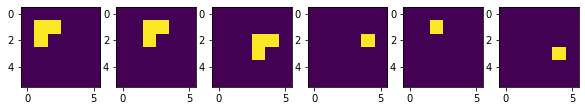

In [49]:
fig, axs = plt.subplots(nrows=1, ncols=6, figsize=(10, 15))
# plotting the loss
axs[0].imshow(X_train[0])
axs[1].imshow(X_train[1])
axs[2].imshow(X_train[2])
axs[3].imshow(X_train[3])
axs[4].imshow(X_train[4])
axs[5].imshow(X_train[5]);

In [50]:
model, losses = simple_fit(X_train, y_train, lr=0.1, epochs=400, verbose=False, scale=1)

c:\Users\henri\AppData\Local\Programs\Python\Python37\lib\site-packages\ipykernel_launcher.py:38: RuntimeWarning: divide by zero encountered in log10
c:\Users\henri\AppData\Local\Programs\Python\Python37\lib\site-packages\ipykernel_launcher.py:41: RuntimeWarning: divide by zero encountered in true_divide
c:\Users\henri\AppData\Local\Programs\Python\Python37\lib\site-packages\ipykernel_launcher.py:41: RuntimeWarning: invalid value encountered in double_scalars


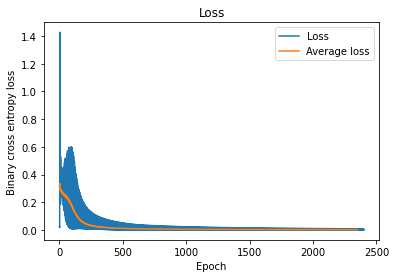

In [51]:
# Average loss over time
N=50
avg = np.convolve(losses, np.ones(N)/N, mode='valid')
# plotting the loss
plt.title("Loss")
plt.xlabel("Epoch")
plt.ylabel("Binary cross entropy loss")
plt.plot(np.linspace(0, len(losses), len(losses)), losses, label="Loss")
plt.plot(np.linspace(0, len(avg), len(avg)), avg, label="Average loss")
plt.legend();

In [52]:
prediction(model, X_train, scale=1)

array([9.96120789e-01, 9.95666523e-01, 9.99999999e-01, 5.03734967e-04,
       1.24717952e-02, 1.88752852e-07])

#### Will it recognize some new data?

(array([1.]), array([0.01791407]))

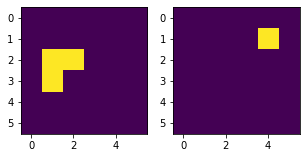

In [53]:
edge4 = np.array([[0,0,0,0,0, 0], [0,0,0,0,0,0], [0,1,1,0,0,0], [0,1,0,0,0,0], [0,0,0,0,0,0], [0, 0, 0, 0, 0, 0]])
singles4 = np.array([[0,0,0,0,0,0], [0,0,0,0,1,0], [0,0,0,0,0,0], [0,0,0,0,0,0], [0,0,0,0,0,0], [0, 0, 0, 0, 0, 0]])
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(5, 8))
# plotting the loss
axs[0].imshow(edge4)
axs[1].imshow(singles4)

prediction(model, [edge4], scale=1), prediction(model, [singles4], scale=1)


#### Looking at batching

Is there an effect on accuracy / on jitter / on performance

In [86]:
def simple_batch_fit(X_train, y_train, lr=0.1, epochs=10, verbose=False, scale=255, batch_size=32):
    # Initialize randomly
    b1 = 1.0 # conv Bias
    F = np.array([[-0.5,0.5, -0.5],[-0.5,0.5, -0.5], [-0.5,0.5, -0.5]]) # Kernel
    #F = np.array([[0.1,-0.1],[-0.1,0.1]]) # Kernel
    w4 = None 
    b4 = 0 # neuron Bias
    lr = lr # Learning rate
    losses = []
    deltas = []
    b1s = []
    b4s = []

    for e in range(epochs):
        batch_loss=0
        batch_delta=0
        for i, X in enumerate(X_train):
            X = X/scale # normalize
            ####################
            ### Forward pass ###
            ####################
            # Convolution
            z1 = convolution(X, F, b1, s=1) # Perform convolution
            a1 = ReLU(z1) # Apply AF
            # Maxpool and flatten
            a2, max_idx = max_pool(a1, k=2, s=2)
            a3 = a2.flatten()
            # Initialize to correct size
            if e==0 and i==0:
                w4 = np.random.randn(len(a3))
            # Fully-connected layer
            z4 = w4.dot(a3) + b4
            a4 = sigmoid(z4)
            # Loss
            loss = bce_loss(y_train[i], a4)
            delta = d_bce_loss(y_train[i], a4) * d_sigmoid(z4)
            if math.isnan(loss):
                # Could not find solution, restarting
                return simple_fit(X_train, y_train, lr=lr, epochs=epochs, verbose=verbose, scale=scale)

            batch_loss+=loss/batch_size
            batch_delta+=delta/batch_size

            if i>0 and i%batch_size==0:
                losses.append(batch_loss)
                deltas.append(batch_delta)

                
                ####################
                ### Backward pass ##
                ####################
                # Fully connected layer:
                delta = batch_delta
                b4 = b4 - lr * delta # Update bias
                delta = delta * a3 # Gradient wrt. w4
                w4 = w4 - lr * delta # Update weights

                # NEXT, we unflatten the backpropagated derivative:
                delta = delta.reshape(a2.shape)
                # maxpooling layer
                d = np.zeros(a1.shape)
                for idx, grad in zip(max_idx, delta.flatten()):
                    i, j = idx[0], idx[1]
                    d[i,j] = grad
                delta = d
                # Backprop through delta
                delta = d_ReLU(z1) * delta
                # The conv bias
                grad_b1 = delta.sum() # dL/d(b1)
                b1 = b1 - lr * grad_b1 # Update bias
                # The conv kernel
                grad_F = convolution(X, delta)
                F = F - lr * grad_F # Update weights

                batch_loss = 0
                batch_delta = 0
                b1s.append(b1)
                b4s.append(b4)

    model = {"b1":b1, "F":F, "b4":b4, "w4":w4}
    return model, losses, b1s, b4s

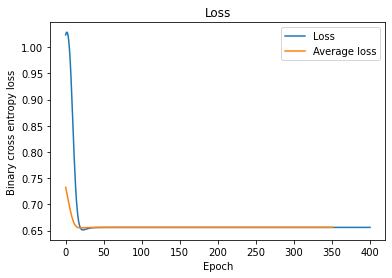

In [87]:
model_batch, losses_batch, b1, b4 = simple_batch_fit(X_train, y_train, lr=0.02, epochs=400, verbose=False, scale=1, batch_size=3)
prediction(model_batch, X_train, scale=1)

# Average loss over time
N=50
avg = np.convolve(losses_batch, np.ones(N)/N, mode='valid')
# plotting the loss
plt.title("Loss")
plt.xlabel("Epoch")
plt.ylabel("Binary cross entropy loss")
plt.plot(np.linspace(0, len(losses_batch), len(losses_batch)), losses_batch, label="Loss")
plt.plot(np.linspace(0, len(avg), len(avg)), avg, label="Average loss")
plt.legend();

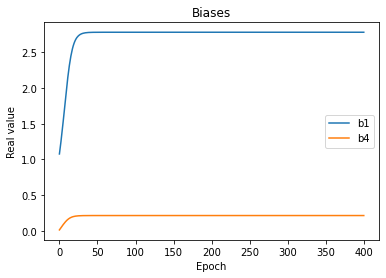

In [90]:
# plotting
plt.title("Biases")
plt.xlabel("Epoch")
plt.ylabel("Real value")
plt.plot(np.linspace(0, len(b1), len(b1)), b1, label="b1")
plt.plot(np.linspace(0, len(b4), len(b4)), b4, label="b4")
plt.legend();


c:\Users\henri\AppData\Local\Programs\Python\Python37\lib\site-packages\ipykernel_launcher.py:38: RuntimeWarning: divide by zero encountered in log10
c:\Users\henri\AppData\Local\Programs\Python\Python37\lib\site-packages\ipykernel_launcher.py:38: RuntimeWarning: invalid value encountered in multiply


Preds: [9.81616694e-01 9.87284275e-01 9.99506086e-01 1.45146042e-03
 5.92215072e-02 2.96261427e-07]


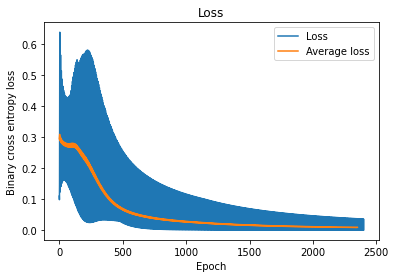

In [82]:
model, losses = simple_fit(X_train, y_train, lr=0.02, epochs=400, verbose=False, scale=1)
print("Preds:", prediction(model, X_train, scale=1))

# Average loss over time
N=50
avg = np.convolve(losses, np.ones(N)/N, mode='valid')
# plotting the loss
plt.title("Loss")
plt.xlabel("Epoch")
plt.ylabel("Binary cross entropy loss")
plt.plot(np.linspace(0, len(losses), len(losses)), losses, label="Loss")
plt.plot(np.linspace(0, len(avg), len(avg)), avg, label="Average loss")
plt.legend();